In [4]:
print("helloooo")

helloooo


In [64]:
from river.tree import HoeffdingTreeClassifier
from river import stream
from river import metrics
from river import evaluate

import time
import datetime as dt
import pandas as pd
import os
import random

import argparse
import matplotlib.pyplot as plt

#note some code copied across from examples provided in handout (loading data mostly)
PATH_TO_DATA = "C:/Users/Bayde/Desktop/Hoeffding_Tree_Project_Data/datasets_csv"
       
    
"""
Grace period: The number of instances a leaf should observe between split attempts. Range
of values (10; 200). Step = 10.

Split Confidence: The allowable error in split decision. Range of values (0.0; 1.0). Step =
0.05.

Tie Threshold: Threshold below which a split will be forced to break ties. Range of values
(0.0; 1.0). Step = 0.05.
"""
        
        
def model_size(model):
    if str(model) == 'HoeffdingTreeClassifier':
        return model.n_nodes
    elif str(model) == 'ARFClassifier':     # In case we are interested in counting the number of nodes from all trees.
        nodes = 0
        for m in model.models:
            nodes += m.model.n_nodes
        return nodes
    return -1


def run_experiment(ensemble, dataset, window_size):
    accuracy = metrics.Accuracy()
    start = time.perf_counter()

    X, Y = dataset[:, :-1], dataset[:, -1]
    # Downsampling the data
    # Select every 20th element starting from the first element
    # Useful during development, when you are making sure your
    #    algorithm works before doing the actual experiments.
    
    X, Y = X[::5], Y[::5]  #TODO: <--- Remember to remove downsampling

    accuracies = []
    predictions = []
    plotacc = []
    
    for x in range(len(ensemble)):
        accuracies.append(metrics.Accuracy())
        predictions.append([])
        
    en_acc = metrics.Accuracy()
    en_predict = []
    
    candidate = new_tree()
    cand_acc = metrics.Accuracy()
    cand_pre = []
        
    ds = stream.iter_array(X, Y)
    counter = 0
    for (x, y) in ds:
        
        #trees:
        for i in range(len(ensemble)):
            yp = ensemble[i].predict_one(x)
            predictions[i].append(yp)
            ensemble[i].learn_one(x, y)
            accuracies[i].update(y,yp)
         
        #candidate tree:
        cyp = candidate.predict_one(x)
        cand_pre.append(cyp)
        candidate.learn_one(x, y)
        cand_acc.update(y,cyp)
        
        #ensemble:
        en_predict.append(vote(predictions, counter, accuracies))
        en_acc.update(y, en_predict[counter])
        plotacc.append(en_acc.get())
        
        
        if counter % window_size == 0: # Candidate tree time
            
            # if tree better than weakest swap in
            if cand_acc.get() < min(acc.get() for acc in accuracies):
                #print("IGNORED")
                continue
            else:
                lowest_index = 99
                lowest_val = 1
                for x in range(len(ensemble)):
                    if accuracies[x].get() < lowest_val:
                        lowest_index = x
                        lowest_val = accuracies[x].get()
                ensemble[lowest_index] = candidate
                #print("SWAPPED (", cand_acc.get(), " > ", lowest_val, ")")
                
            candidate = new_tree() # instantiate new candidate 
                
            
        
        counter = counter +1
        #accuracy.update(y, yp)
        #print("Ensemble: {:.2f} Candidate: {:.2f} Trees: {}".format(en_acc.get(), cand_acc.get(), accuracies))
     
    return (en_acc.get(), plotacc)
    #return accuracy.get(), dt.timedelta(seconds=time.perf_counter() - start).seconds, model_size(model)

    
def vote(pred, count, acc):
    w = {} # votes
    for model_num in range(len(pred)):
        # Get the prediction for the current model and instance
        prediction = pred[model_num][count] 
        accuracy = acc[model_num].get()

        if prediction not in w:
            w[prediction] = 0
        w[prediction] += accuracy

    # Grab max weighted value class
    ensemble_prediction = max(w, key=w.get)
    return ensemble_prediction
        
        
def new_tree():
    # Random grace period from the range (10, 200) with step = 10
    gp = random.choice(range(10, 201, 10))

    # Random split_confidence from the range (0.0, 1.0) with step = 0.05
    sc = random.choice([i * 0.05 for i in range(1, 21)])

    # Random tau from the range (0.0, 1.0) with step = 0.05
    t = random.choice([i * 0.05 for i in range(21)])

    new_model = HoeffdingTreeClassifier(
        grace_period=gp,
        delta=sc,
        tau=t)
    return new_model
    
    
def ensem(num_learners):
    ensemble = []
    for x in range(num_learners):
        tree = new_tree()
        ensemble.append(tree) 
    return ensemble
    
    
    
def main(num_learners, window_size, seed):
    random.seed(seed)
    # Optional HyperParameter Arguments for base HT Classifier, default is (10,0,0)
    print(f"Number of learners: {num_learners}")
    print(f"Candidate window size: {window_size}")
    
    datasets = ['electricity.csv', 'SEA_abrupt.csv', 'SEA_gradual.csv',
                'RTG_2abrupt.csv', 'covtype.csv']

    
    dataset_res = []
    
    
    dataset_res.append(datasets)
    text = ("[ " + "Learners: " +  str(num_learners) + "Window: " + str(window_size) + "Seed: " + str(seed) + " ]")
    dataset_res.append(text)        

    for name in datasets: # For Each Dataset
        ensemble = ensem(num_learners)
        dataset = pd.read_csv(os.path.join(PATH_TO_DATA, name)).to_numpy()
        results = run_experiment(ensemble, dataset, window_size)
        dataset_res.append(results)
    print("---DONE---")
    return(dataset_res)
        

#         for model in models: # For Each Model
#             result = run_experiment(model, dataset)
#             print('Dataset: ', name, ' Learner: ', model, ' Result: ', result, "(Accuracy, Time,  Size)")

            
            
if __name__ == '__main__':
#     parser = argparse.ArgumentParser(
#         description='hyperparameters for ensemble, default number of learners is 10, default candidate window is 1000.')

#     parser.add_argument('--S', type=int, choices=range(1, 50, 1),
#                         help='The number of trees', default=10)

#     parser.add_argument('--L', type=int, choices=range(1, 15000, 1),
#                         help='The size of the candidate window', default=1000)
#     args = parser.parse_args()
    
    #args = argparse.Namespace(S=4, L=1000) #TODO remove this when not using jupyter notebook, its needed so arguments dont brick the code
    #main(args.S, args.L, 42)
    print("pass")
    


pass


Number of learners: 5
Candidate window size: 1000
---DONE---
['electricity.csv', 'SEA_abrupt.csv', 'SEA_gradual.csv', 'RTG_2abrupt.csv', 'covtype.csv']
[ Learners: 5Window: 1000Seed: 42 ]
0.7878186031115525


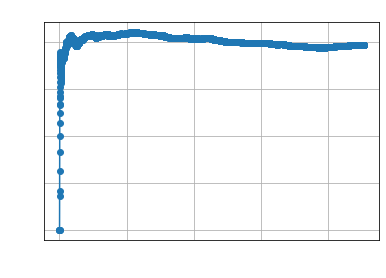

0.6566


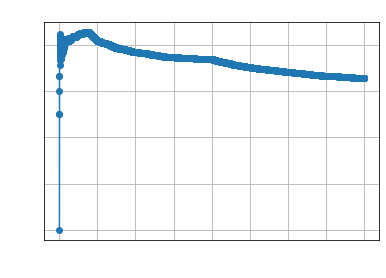

0.6659


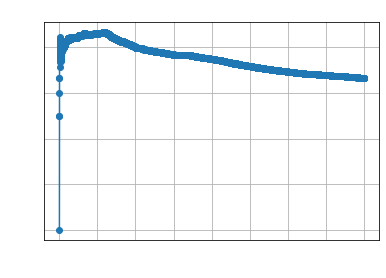

0.473


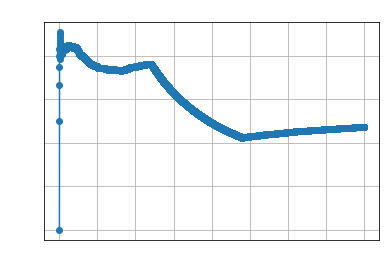

0.3694741099627376


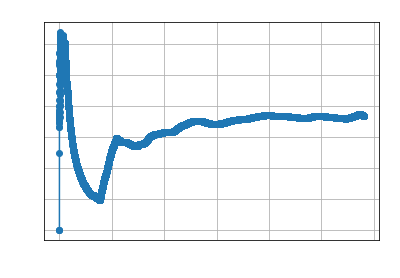

Number of learners: 10
Candidate window size: 1000
---DONE---
['electricity.csv', 'SEA_abrupt.csv', 'SEA_gradual.csv', 'RTG_2abrupt.csv', 'covtype.csv']
[ Learners: 10Window: 1000Seed: 42 ]
0.7901357166501158


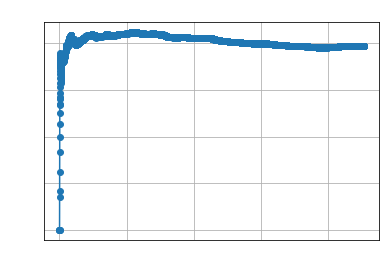

0.44485


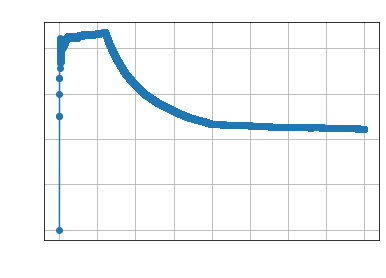

0.5362


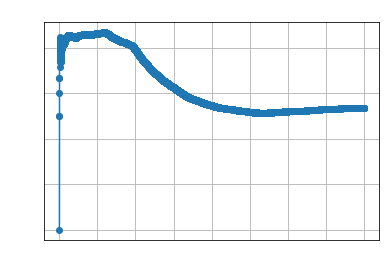

0.37005


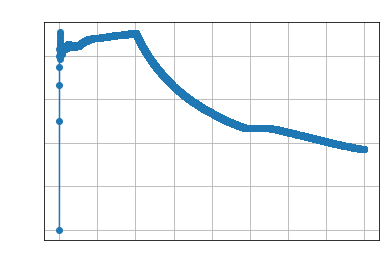

0.3997487156097519


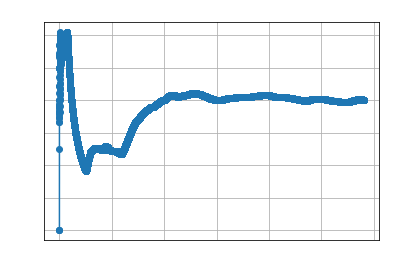

Number of learners: 20
Candidate window size: 1000
---DONE---
['electricity.csv', 'SEA_abrupt.csv', 'SEA_gradual.csv', 'RTG_2abrupt.csv', 'covtype.csv']
[ Learners: 20Window: 1000Seed: 42 ]
0.7893633454705947


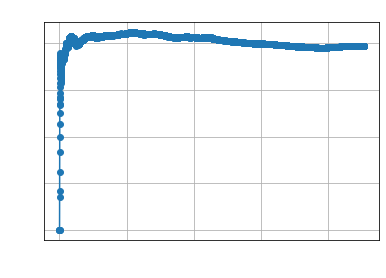

0.6737


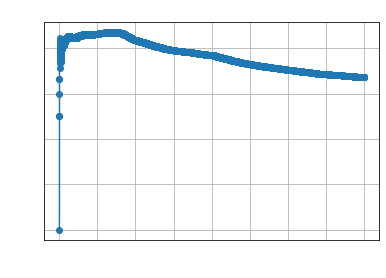

0.67235


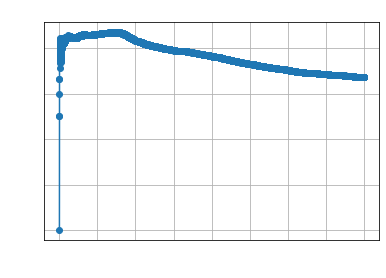

0.523


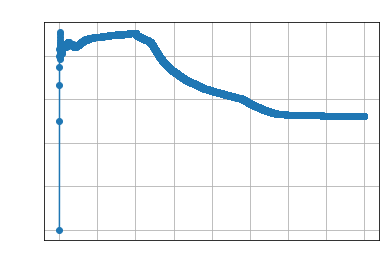

0.40769171191793674


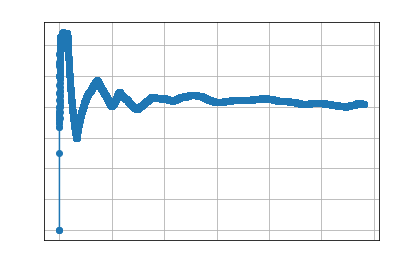

Number of learners: 30
Candidate window size: 1000


In [ ]:
one = main(5, 1000, 42)
print(one[0])
print(one[1])


for x in range(5):
    print(one[2+x][0])
    x_values = range(1, len(one[2+x][1]) + 1)
    plt.plot(x_values, one[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

two = main(10, 1000, 42)
print(two[0])
print(two[1])


for x in range(5):
    print(two[2+x][0])
    x_values = range(1, len(two[2+x][1]) + 1)
    plt.plot(x_values, two[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

three = main(20, 1000, 42)
print(three[0])
print(three[1])


for x in range(5):
    print(three[2+x][0])
    x_values = range(1, len(three[2+x][1]) + 1)
    plt.plot(x_values, three[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

four = main(30, 1000, 42)
print(four[0])
print(four[1])


for x in range(5):
    print(four[2+x][0])
    x_values = range(1, len(four[2+x][1]) + 1)
    plt.plot(x_values, four[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

In [ ]:
one = main(20, 1000, 1)
print(one[0])
print(one[1])


for x in range(5):
    print(one[2+x][0])
    x_values = range(1, len(one[2+x][1]) + 1)
    plt.plot(x_values, one[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

two = main(20, 1000, 2)
print(two[0])
print(two[1])


for x in range(5):
    print(two[2+x][0])
    x_values = range(1, len(two[2+x][1]) + 1)
    plt.plot(x_values, two[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

three = main(20, 1000, 3)
print(three[0])
print(three[1])


for x in range(5):
    print(three[2+x][0])
    x_values = range(1, len(three[2+x][1]) + 1)
    plt.plot(x_values, three[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

four = main(20, 1000, 4)
print(four[0])
print(four[1])


for x in range(5):
    print(four[2+x][0])
    x_values = range(1, len(four[2+x][1]) + 1)
    plt.plot(x_values, four[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()
    
five = main(20, 1000, 5)
print(five[0])
print(five[1])


for x in range(5):
    print(five[2+x][0])
    x_values = range(1, len(five[2+x][1]) + 1)
    plt.plot(x_values, five[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

In [ ]:
one = main(20, 500, 42)
print(one[0])
print(one[1])


for x in range(5):
    print(one[2+x][0])
    x_values = range(1, len(one[2+x][1]) + 1)
    plt.plot(x_values, one[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

two = main(20, 1000, 42)
print(two[0])
print(two[1])


for x in range(5):
    print(two[2+x][0])
    x_values = range(1, len(two[2+x][1]) + 1)
    plt.plot(x_values, two[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

three = main(20, 2000, 42)
print(three[0])
print(three[1])


for x in range(5):
    print(three[2+x][0])
    x_values = range(1, len(three[2+x][1]) + 1)
    plt.plot(x_values, three[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()

four = main(20, 5000, 42)
print(four[0])
print(four[1])


for x in range(5):
    print(four[2+x][0])
    x_values = range(1, len(four[2+x][1]) + 1)
    plt.plot(x_values, four[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()
    
five = main(20, 10000, 4)
print(five[0])
print(five[1])


for x in range(5):
    print(five[2+x][0])
    x_values = range(1, len(five[2+x][1]) + 1)
    plt.plot(x_values, five[2+x][1], marker='o')
    plt.xlabel('Amount of Instances', color='white')
    plt.ylabel('Accuracy', color='white')
    plt.title('Accuracy Over Amount of Instances', color='white')
    plt.tick_params(colors='white', which='both')
    plt.grid(True)
    plt.show()